##### <h1 id="aa" align="center" style="color:white;background:#8B0000;padding:18px;border-radius:15px 15px;"> РЕКОМЕНДОВАТЕЛЬНАЯ СИСТЕМА ФИЛЬМОВ </h1> #####

Цели и задачи проекта:

Разработайте программный интерфейс для итоговой модели машинного 
обучения. API должен позволить приложению пользователя получать:  
1) списка топ-10 популярных фильмов (на основе взвешенных 
рейтингов); 
2) доступ к рекомендательной системе для прогнозирования списка 10 
рекомендованных фильмов по жанру; 
3) доступ к рекомендательной системе для прогнозирования списка 10 
рекомендованных фильмов по контенту (по названию фильма); 
4) доступ к рекомендательной системе для прогнозирования списка 10 
рекомендованных фильмов по контенту (коллаборативная 
фильтрация)

___

In [ ]:
!pip install kaggle google pandas scikit-learn matplotlib
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir -p /content/data
!kaggle datasets download -d rounakbanik/the-movies-dataset -p /content/data --unzip --force

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
df_movies = pd.read_csv("/content/data/movies_metadata.csv")
df_credits = pd.read_csv("/content/data/credits.csv")
df_keywords = pd.read_csv("/content/data/keywords.csv")
df_ratings = pd.read_csv("/content/data/ratings_small.csv")
df_links = pd.read_csv("/content/data/links.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/data/movies_metadata.csv'

In [ ]:
df_movies

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
df_movies.info(verbose=True, show_counts=True)

In [ ]:
df_movies.duplicated().sum()

In [ ]:
df_movies.describe().T

### Титры

In [ ]:
df_credits

In [ ]:
df_credits.info(verbose=True, show_counts=True)

In [ ]:
df_credits.duplicated().sum()

In [ ]:
df_credits.describe().T

### Ключевые слова

In [ ]:
df_keywords

In [ ]:
df_keywords.info(verbose=True, show_counts=True)

In [ ]:
df_keywords.duplicated().sum()

In [ ]:
df_keywords.describe().T

### Рейтинги

In [ ]:
df_ratings

In [ ]:
df_ratings.info(verbose=True, show_counts=True)

In [ ]:
df_ratings.duplicated().sum()

In [ ]:
df_ratings.describe().T

### Ссылки

In [ ]:
df_links

In [ ]:
df_links.info(verbose=True, show_counts=True)

In [ ]:
df_links.duplicated().sum()

In [ ]:
df_links.describe().T

## Трансформация

In [ ]:
df_movies = df_movies.dropna(subset=['vote_average', 'vote_count', 'title'])

In [ ]:
df_movies['vote_count'] = pd.to_numeric(df_movies['vote_count'], errors='coerce')
df_movies['vote_average'] = pd.to_numeric(df_movies['vote_average'], errors='coerce')

df_movies = df_movies.dropna(subset=['vote_count', 'vote_average'])

In [ ]:
def parse_genres(genres_str):
    try:
        genres_list = ast.literal_eval(genres_str)
        if isinstance(genres_list, list):
            return '|'.join([genre['name'] for genre in genres_list])
        else:
            return ''
    except Exception:
        return ''
    
df_movies['genres'] = df_movies['genres'].apply(parse_genres)

In [ ]:
C = df_movies['vote_average'].mean()
m = df_movies['vote_count'].quantile(0.90)

print(f"Средний рейтинг по всем фильмам (C): {C:.2f}")
print(f"Минимальное количество голосов (m): {m:.0f}")

Средний рейтинг по всем фильмам (C): 5.62
Минимальное количество голосов (m): 160


In [ ]:
def weighted_rating(df, m=m, C=C):
    v = df['vote_count']
    R = df['vote_average']
    return (v / (v + m) * R) + (m / (v + m) * C)

df_movies['weighted_rating'] = df_movies.apply(weighted_rating, axis=1)

In [ ]:
top_10 = df_movies[['title', 'weighted_rating', 'vote_count', 'vote_average']].sort_values('weighted_rating', ascending=False).head(10)
print("Топ-10 фильмов по взвешенному рейтингу:")
print(top_10)

Топ-10 фильмов по взвешенному рейтингу:
                             title  weighted_rating  vote_count  vote_average
314       The Shawshank Redemption         8.445869      8358.0           8.5
834                  The Godfather         8.425439      6024.0           8.5
10309  Dilwale Dulhania Le Jayenge         8.421453       661.0           9.1
12481              The Dark Knight         8.265477     12269.0           8.3
2843                    Fight Club         8.256385      9678.0           8.3
292                   Pulp Fiction         8.251406      8670.0           8.3
522               Schindler's List         8.206639      4436.0           8.3
23673                     Whiplash         8.205404      4376.0           8.3
5481                 Spirited Away         8.196055      3968.0           8.3
2211             Life Is Beautiful         8.187171      3643.0           8.3


___

## Обогащение данных (Объединяем с credits и keywords)

In [ ]:
def getDirector(crew_str):
    try:
        crew_list = ast.literal_eval(crew_str)
        for person in crew_list:
            if person['job'] == 'Director':
                return person['name']
        return ''
    except Exception:
        return ''

def getThreeActors(cast_str):
    try:
        cast_list = ast.literal_eval(cast_str)
        if isinstance(cast_list, list):
            actors = [actor['name'] for actor in cast_list[:3]] # Берем первых 3-х актеров
            return '|'.join(actors)
        else:
            return ''
    except Exception:
        return ''

def get_keywords(keywords_str):
    try:
        keywords_list = ast.literal_eval(keywords_str)
        if isinstance(keywords_list, list):
            keywords = [kw['name'] for kw in keywords_list]
            return '|'.join(keywords)
        else:
            return ''
    except Exception:
        return ''
    

df_credits['director'] = df_credits['crew'].apply(getDirector)
df_credits['actors'] = df_credits['cast'].apply(getThreeActors)
df_keywords['parsed_keywords'] = df_keywords['keywords'].apply(get_keywords)

In [ ]:
def safeConvert(df, column_name):
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    df = df.dropna(subset=[column_name])
    df[column_name] = df[column_name].astype('int64')
    return df

# конвертируем id
df_movies = safeConvert(df_movies, 'id')
df_credits = safeConvert(df_credits, 'id')
df_keywords = safeConvert(df_keywords, 'id')

In [ ]:
df_movies = df_movies.merge(df_credits[['id', 'director', 'actors']], on='id', how='left')
df_movies = df_movies.merge(df_keywords[['id', 'parsed_keywords']], on='id', how='left')

In [ ]:
df_movies['director'] = df_movies['director'].fillna('')
df_movies['actors'] = df_movies['actors'].fillna('')
df_movies['parsed_keywords'] = df_movies['parsed_keywords'].fillna('')
df_movies['overview'] = df_movies['overview'].fillna('')

In [ ]:
df_movies['metadata_soup'] = (
    df_movies['overview'] + ' ' + 
    df_movies['director'] + ' ' + 
    df_movies['actors'] + ' ' + 
    df_movies['parsed_keywords'] + ' ' + 
    df_movies['genres']
)

In [ ]:
columns_to_drop = [
    'adult',
    'belongs_to_collection',
    'budget',
    'homepage',
    'imdb_id',
    'original_language',
    'original_title',
    'production_companies',
    'production_countries',
    'revenue',
    'spoken_languages', 
    'status',
    'tagline',
    'video', 
    'poster_path',
]

df_movies = df_movies.drop(columns=columns_to_drop, errors='ignore')

### Подготовка данных для коллаборативной фильтрации

In [ ]:
df_links = safeConvert(df_links, 'tmdbId')

In [ ]:
ratings_merged = df_ratings.merge(df_links[['movieId', 'tmdbId']], on='movieId', how='inner')

ratings_merged = ratings_merged.rename(columns={'tmdbId': 'id'})
ratings_final = ratings_merged.merge(df_movies[['id', 'title']], on='id', how='inner')
ratings_final = ratings_final[['userId', 'id', 'rating', 'title']]
ratings_final = ratings_final.rename(columns={'id': 'movie_id'})

print("Размер итогового датафрейма:", ratings_final.shape)
print(ratings_final.head())

## Оптимизированные рекомендации

**Топ-10 популярных фильмов на основе взвешенных рейтингов**

In [ ]:
df_movies_copy = df_movies.copy()

In [ ]:
# Рассчитываем параметры для формулы
v = df_movies_copy["vote_count"]
R = df_movies_copy["vote_average"]
m = v.quantile(0.90)
c = R.mean()

print(f"Пороговое значение количества оценок (m): {m:.0f}")
print(f"Средний рейтинг по всем фильмам (c): {c:.2f}")

In [ ]:
# Применяем упрощенную формулу
df_movies_copy['w_score'] = ((v * R) + (m * c)) / (v + m)

In [ ]:
top_10_new = df_movies_copy.sort_values('w_score', ascending=False).head(10)
print("Топ-10 фильмов:")
print(top_10_new[['title', 'w_score', 'vote_average', 'vote_count']])

C:\Users\user\AppData\Local\Temp\ipykernel_4876\1881408928.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='w_score', y='title', data=top_10_popular_new, palette='magma')


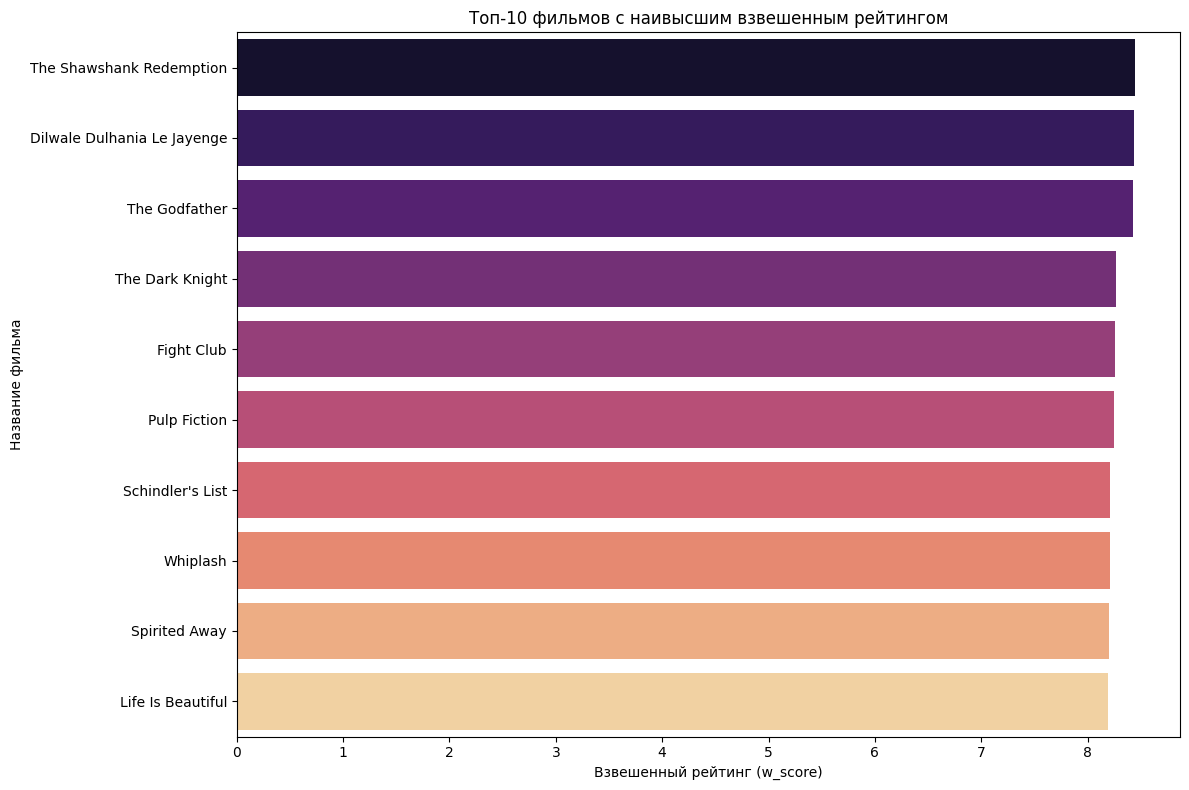

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='w_score', y='title', data=top_10_new, palette='magma')
plt.xlabel('Взвешенный рейтинг (w_score)')
plt.ylabel('Название фильма')
plt.title('Топ-10 фильмов с наивысшим взвешенным рейтингом')
plt.tight_layout()
plt.show()

**Рекомендации по жанру**

In [ ]:
def get_top_movies_by_genre(genre_name, n=10):
    genre_movies = df_movies[df_movies['genres'].str.contains(genre_name, case=False, na=False)]
    return genre_movies.sort_values('weighted_rating', ascending=False).head(n)

get_top_movies_by_genre('Drama')

**Content-Based по названию фильма**

In [ ]:
min_votes = 50
popular_movies = df_movies[df_movies['vote_count'] >= min_votes].copy()

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(popular_movies['metadata_soup'])

model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(tfidf_matrix)

indices = pd.Series(popular_movies.index, index=popular_movies['title']).drop_duplicates()

def recommend(title, n=10):
    if title not in indices:
        return f"Фильм '{title}' не найден в базе данных"
    idx = indices[title]
    distances, indices_knn = model_knn.kneighbors(tfidf_matrix[idx], n_neighbors=n+1)
    similar_indices = indices_knn[0][1:]  # пропускаем сам фильм
    return popular_movies.iloc[similar_indices][['title', 'genres', 'weighted_rating']]

recommend('Toy Story')

## Коллаборативная фильтрация через pivot_table и корреляцию

In [ ]:
ratings_pivot = ratings_final.pivot_table(index='userId', columns='title', values='rating')
ratings_pivot.fillna(0, inplace=True)
ratings_pivot.head()

C:\Users\user\AppData\Local\Temp\ipykernel_4876\1973325628.py:3: PerformanceWarning: The following operation may generate 2383918007 cells in the resulting pandas object.
  ratings_pivot = ratings_final.pivot_table(index='userId', columns='title', values='rating')


MemoryError: Unable to allocate 2.22 GiB for an array with shape (270623, 8809) and data type bool

In [ ]:
def same_movies(movie):
    users_vote_film = ratings_pivot[movie]
    similar_with = ratings_pivot.corrwith(users_vote_film)
    similar_with = pd.DataFrame(similar_with, columns=['correlation'])
    similar_with = similar_with.drop(movie, errors='ignore')
    return similar_with.sort_values('correlation', ascending=False).head(10)

same_movies('The Dark Knight')

## Сохранение моделей

In [ ]:
top_10_new.to_csv('top_10_popular.csv', index=False) # Топ 10
df_movies.to_csv('movies_metadata_clean.csv', index=False) # По жанру

with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(model_knn, f)
popular_movies.to_csv('popular_movies.csv', index=False) # По содержанию

ratings_pivot.to_csv('ratings_pivot.csv') # Коллаборативная фильтрация